# Simple Trading Algorithm


                          open       high        low      close      volume
timestamp                                                                  
2025-06-17 00:00:00  106794.53  107262.31  106115.35  107238.63  1478.91948
2025-06-17 01:00:00  107238.68  107399.00  106930.23  107173.51   437.59004
2025-06-17 02:00:00  107173.51  107600.00  106572.07  107482.39   551.95383
2025-06-17 03:00:00  107482.40  107771.34  107364.89  107590.41   557.48911
2025-06-17 04:00:00  107590.41  107711.06  107303.01  107333.64   324.27105


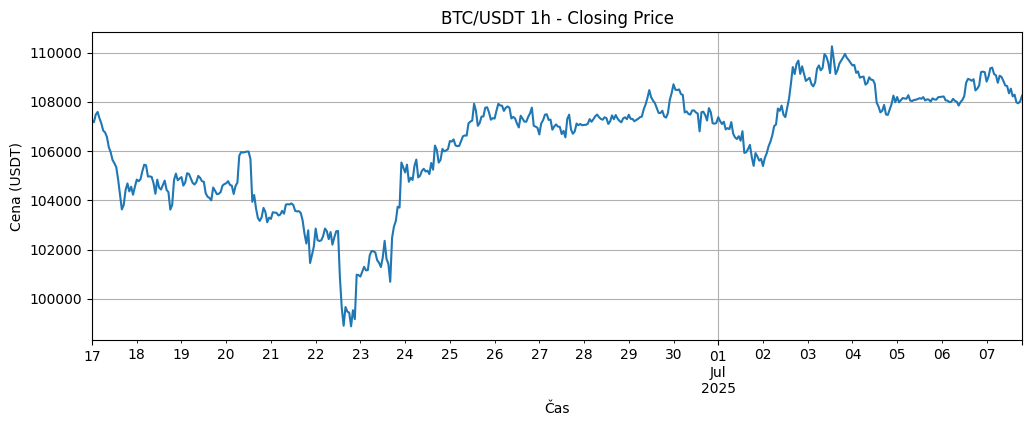

In [ ]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt

# Connect to Binance through CCXT
exchange = ccxt.binance()

# Parametry
symbol = 'BTC/USDT'
timeframe = '1h'
limit = 500  # last 500 horurs

# Download of OHLCV data
ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

print(df.head())

# closing price
plt.figure(figsize=(12, 4))
df['close'].plot(title='BTC/USDT 1h - Closing Price')
plt.xlabel('Čas')
plt.ylabel('Cena (USDT)')
plt.grid(True)
plt.show()


In [4]:
# Parameters Bollinger Bands
window = 20  # 20 hours
df['sma'] = df['close'].rolling(window=window).mean()
df['std'] = df['close'].rolling(window=window).std()

# upper lower boundary
df['upper_band'] = df['sma'] + 2 * df['std']
df['lower_band'] = df['sma'] - 2 * df['std']

# Initiating signal
df['position'] = 0  # 1 = long

# Input below
df.loc[df['close'] < df['lower_band'], 'position'] = 1

# Output above SMA
df.loc[df['close'] > df['sma'], 'position'] = 0

# Keep the position until last signal
df['position'] = df['position'].ffill()


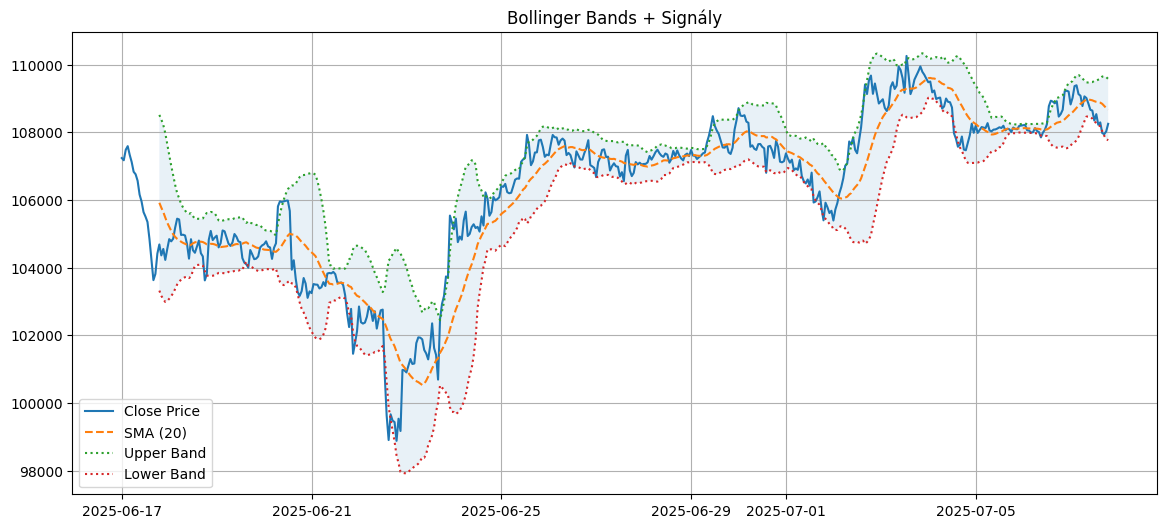

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Close Price')
plt.plot(df['sma'], label='SMA (20)', linestyle='--')
plt.plot(df['upper_band'], label='Upper Band', linestyle=':')
plt.plot(df['lower_band'], label='Lower Band', linestyle=':')
plt.fill_between(df.index, df['lower_band'], df['upper_band'], alpha=0.1)
plt.title('Bollinger Bands + Signály')
plt.legend()
plt.grid(True)
plt.show()
